<a href="https://colab.research.google.com/github/tamaricki/Projects/blob/main/brainScans_classification_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuer Abschnitt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir('/content/drive/MyDrive')

In [3]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import glob

In [4]:
#classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train_list = glob.glob('./Training/*/*.jpg')
path = './Training'

test_list = glob.glob('./Testing/*/*.jpg')


In [20]:
print(train_list[-3:])
print(test_list[-3:])

['./Training/pituitary_tumor/p (687).jpg', './Training/pituitary_tumor/p (745).jpg', './Training/pituitary_tumor/p (563).jpg']
['./Testing/pituitary_tumor/image(3).jpg', './Testing/pituitary_tumor/image(19).jpg', './Testing/pituitary_tumor/image(67).jpg']


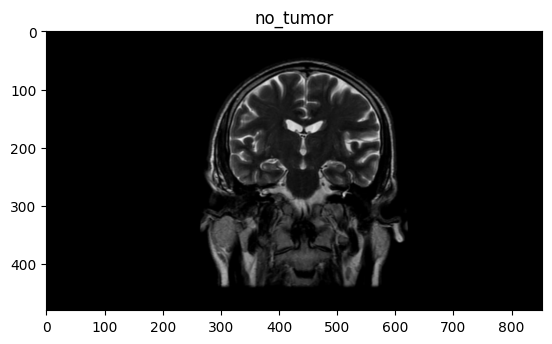

In [5]:
plt.imshow(plt.imread(train_list[2001]))
plt.title(train_list[2001].split('/')[2])
plt.show()

In [ ]:
image = np.array(plt.imread(train_list[1022]))
image.shape

(500, 455, 3)

- we will transform it tensor, thne reduce shape to match the format of resnet. this would mean we would need to reduce channel number to 1
- for test dataset we do not do this transformation, we just need to transform to tensor

In [ ]:
from PIL import Image
def channel_to_one(img_path):
  img = Image.open(img_path)
  new = img.convert('L') # this changes num of chanels from 3 to 1
  one_ch = new.expand_dims(new, axis=-1)
  return one_ch

For image transformation the order of transformation step is important; for instance if we resize the image before transforming to tensor, it will not change the size.

In this case we are changing the channel size to 1, since we will use pretrained model and input size of its classifier is not mathichng with current image shape and 3 channels. And in this case normalization should be applied only for one channel and not for 3, and it should be applied after reducing no. of channels (logically ).  

In [6]:
#images used for whole model
train_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#for option where we train just classifier, #for resnet we need to transform the size to get product of 512 (no. of channels is 3, so  32 x 16)
#train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor(), transforms.Resize((32,16))])
dataset_train_resnet = ImageFolder(path, transform=train_transforms)

In [7]:
test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
#we leave original pictures, just transform to tensor , and resizein order to validate
#test_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor(), transforms.Resize((32, 16))]) #does this need to be 64 x 64 like model below or not? these are not channels(3 here)
dataset_test_resnet = ImageFolder('./Testing', transform=test_transforms)

In [8]:
print(dataset_train_resnet.class_to_idx)
print(dataset_test_resnet.class_to_idx)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [9]:
dataset_train_resnet[9][0].shape

torch.Size([3, 224, 224])

class_to_idx to identify classes and corresponding labels

next, we will create custom cnn model, then train / eval function, which will transform dataset to dataloader, and train on  

In [ ]:
class Net(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.feature_extractor1 = nn.Sequential(
                              nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(64,64, kernel_size=3, padding=1),
                              nn.ReLU(inplace=True),
                              nn.MaxPool2d(kernel_size=2, stride=2)
     ) # image size split to two 64 x64 x64
    self.feature_extractor2 = nn.Sequential(
                              nn.Conv2d(64, 128, kernel_size=3, padding=1),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(128, 128, kernel_size=3, padding=1),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(128, 256, kernel_size=3, padding=1),
                              nn.ReLU(inplace=True),
                              nn.MaxPool2d(kernel_size=2, stride=2),

    ) #image 256 x32 x32
    self.feature_extractor3 = nn.Sequential(
                              nn.Conv2d(256, 256, kernel_size=3, padding=1),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(256, 512, kernel_size=3, padding=1),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(512, 512, kernel_size=3, padding=1),
                              nn.ReLU(inplace=True),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              nn.Flatten()
    )#image 512 x 16 x16. 16**2 = 256, if I put 1024 (32*32) will not work, need to put 256
    self.classifier = nn.Sequential(
                      nn.Linear(512*16*16, 256),
                      nn.ReLU(inplace=True),
                      nn.Dropout(),
                      nn.Linear(256, num_classes)  #no sigmoid function at the end since nn.CrossEntropy expects logits and not prob values (between 0, and 1)
    )
  def forward(self, x):
    x = self.feature_extractor1(x)
    x= self.feature_extractor2(x)
    x= self.feature_extractor3(x)# instead of defyning nn.Flatten in feature_extractor3 we could here write x= x.view(-1, 512*16*16)
    x= self.classifier(x)
    return x


In [ ]:


#net = Net(num_classes = 4)
#opt_net = torch.optim.Adam(net.parameters(), lr = 0.001)
#criterion = nn.CrossEntropyLoss()


In [9]:
dataloader_train_resnet= DataLoader(dataset_train_resnet, batch_size=4, shuffle=True)
dataloader_test_resnet =DataLoader(dataset_test_resnet, batch_size=4, shuffle=True)

train_size = len(dataset_train_resnet)
train_size1 = len(dataloader_train_resnet.dataset)
test_size =len(dataset_test_resnet)
test_size1 = len(dataloader_test_resnet.dataset)

#sizes of dataset and dataloader
print('Train: ', train_size, train_size1, len(dataloader_train_resnet) )
print('test: ', test_size, test_size1, len(dataloader_test_resnet))

Train:  2870 2870 718
test:  394 394 99


In [10]:
class_names = dataset_train_resnet.classes
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])


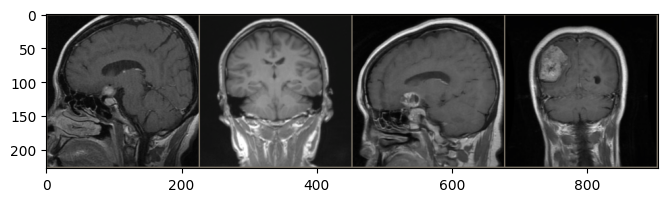

In [11]:
#visualizing images

example, label = next(iter(dataloader_train_resnet))
print(example.size())
print(example.size()[1:])

def show_grid(p):
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  new1 = p.numpy().transpose((1,2,0)) #without function this produces error, however we applying this to batch, so first dimension is num of images
  new = new1*std + mean

  new[new>1] = 1
  new[new <0] = 0
  plt.figure(figsize=(20,2))
  plt.imshow(new)


n_img = 6

out_images = torchvision.utils.make_grid(example[:n_img])
show_grid(out_images)


#e=example.view(example.size(0), -1) # changing the shape for linear layer, or using Flatten()
#print(e.size())

### Training and Validation functions

Let's create training and testing functions. We will do this separately since in previous trials, validation does not seem to work properly, model was not validating per epoch.

In [12]:
print(torch.__version__)
use_gpu = torch.cuda.is_available()
print(use_gpu)


2.1.0+cu118
True


In [24]:

def customModel_validate(model, loader, optimizer):
  model.eval()
  run_loss = 0.0
  run_acc = 0.0
  with torch.no_grad():
    batch_count = 0
    for data in loader:
      img, label = data
      img, label = img.to(device), label.to(device)
      output = model(img)

      loss = criterion(output, label)
      _, preds = torch.max(output.data, 1)

      run_loss +=loss.item()
      run_acc += torch.sum(preds==label).item()

    #avg_loss = run_loss/batch_count
    e_loss = run_loss/len(loader.dataset)
    e_acc = run_acc/len(loader.dataset)
    print('Validation loss:, {} | Validation accuracy: {}'.format(e_loss, e_acc))




#below function only with better resources , it is for custom built models
def customModel_train_validate(model, train_loader, val_loader, optimizer, epochs):

  model.train()
  for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    run_loss = 0.0
    run_acc = 0.0
    for data in train_loader:
      #batch_count+=1
      optimizer.zero_grad()
      feature, label = data
      feature, label = feature.to(device), label.to(device)
      #feature = feature.view(feature.size(0), -1) this not needed we flattened and can be used as input in classifier
      outputs = model(feature)

      loss = criterion(outputs, label)
      _, preds = torch.max(outputs, 1)
      run_loss += loss.item()
      run_acc += torch.sum(preds==label)

      loss.backward()
      optimizer.step()

    e_loss = run_loss / len(train_loader.dataset) # 4 is number of batches
    e_acc = run_acc / len(train_loader.dataset)
    print('Training Loss : {} | Training Accuracy:{} '.format(e_loss, e_acc))

    customModel_validate(model, val_loader, optimizer)




In [25]:
resnet = models.resnet18(weights='IMAGENET1K_V1')
#print(resnet)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This takes too long to perform on colab, therefore, we should use transfer learning for this task. We will try with Resnet18. But for that we need to change the classifier part of the model and during training we might need to change the input (features) shape - make it one dimensional

In [26]:
for w in resnet.parameters():
    w.requires_grad=False

resnet.fc = nn.Linear(in_features=512, out_features = 4)

resnet_opt = torch.optim.SGD(resnet.parameters(), lr=0.001)

resnet.to(device)
### this is for case where we train only classifier
#for w in resnet.fc.parameters():
 #   w.requires_grad=True

#resnet_opt = torch.optim.SGD(resnet.fc.parameters(), lr = 0.001)
#resnet.fc.to(device)

criterion = nn.CrossEntropyLoss()

In [27]:
customModel_train_validate(resnet, dataloader_train_resnet, dataloader_test_resnet, resnet_opt, 35)



Epoch 1/35
Training Loss : 0.2715962091077911 | Training Accuracy:0.5449477434158325 
Validation loss:, 0.32702527085536626 | Validation accuracy: 0.41624365482233505
Epoch 2/35
Training Loss : 0.15827208836319553 | Training Accuracy:0.7777003049850464 
Validation loss:, 0.3241245546921861 | Validation accuracy: 0.46446700507614214
Epoch 3/35
Training Loss : 0.12960457605819253 | Training Accuracy:0.8142856955528259 
Validation loss:, 0.322997728277584 | Validation accuracy: 0.5177664974619289
Epoch 4/35
Training Loss : 0.11442775533563791 | Training Accuracy:0.8397212624549866 
Validation loss:, 0.3442964268668654 | Validation accuracy: 0.5456852791878173
Epoch 5/35
Training Loss : 0.10636925110106685 | Training Accuracy:0.8505226373672485 
Validation loss:, 0.32074261952172683 | Validation accuracy: 0.5786802030456852
Epoch 6/35
Training Loss : 0.09959153790182665 | Training Accuracy:0.8609755635261536 
Validation loss:, 0.336104968893649 | Validation accuracy: 0.5888324873096447
Epo

Did not save the loss and accuracy figures, it is evident that while training loss decreases, validation loss did not change much. On the other hand training and  validation accuracy are constantly increasing.

This is good result knowing that brain scans images are completely different than the images used to train resnet.

In [ ]:

 #is this same as optimizer.zero_grad()
def pretrainedModel_validate(model, size, loader):
  model.eval()
  with torch.no_grad():

    run_loss = 0.0
    run_acc = 0.0
    for data in loader:
      img, label = data
      img= img.view(img.size(0), -1)
      output = model(img)

      loss = criterion(output, label)
      _, preds = torch.max(output, 1)

    run_loss +=loss.item()
    run_acc += torch.sum(preds==label)

  e_loss = run_loss/size
  e_acc = run_acc/size
  print('Validation loss:, {} | Validation accuracy: {} \n'.format(e_loss, e_acc))




In [ ]:
def pretrainedModel_train(model, size, train_loader, val_loader, optimizer, epochs):
  model.train()
  for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))

    run_loss = 0.0
    run_acc = 0.0
    for data in train_loader:
      optimizer.zero_grad()
      feature, label = data
      feature = feature.view(feature.size(0), -1) #for transfer model we need this
      #print('feature size:',feature.size())
      outputs = model(feature)

      loss = criterion(outputs, label)
      _, preds = torch.max(outputs, 1)
      #print('_, preds',_ ,preds)

      loss.backward()
      optimizer.step()
      run_loss += loss.item()
      run_acc += torch.sum(preds==label.data)
    e_loss = run_loss/size
    e_acc = run_acc/size
    print('Train Loss : {} | Train Accuracy: {}'.format(e_loss, e_acc))
    pretrainedModel_validate(model, len(val_loader.dataset), val_loader.dataset)

In [ ]:
pretrainedModel_train(resnet.fc, len(dataset_train_resnet), dataloader_train_resnet, dataloader_test_resnet, resnet_opt, 3)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Loss : 0.28398760482409274 | Train Accuracy: 0.5240418314933777
Validation loss:, 0.014380481508043077 | Validation accuracy: 0.010101010091602802 

Epoch 2/3
Train Loss : 0.23969555709004817 | Train Accuracy: 0.6153309941291809
Validation loss:, 0.01719749335086707 | Validation accuracy: 0.010101010091602802 

Epoch 3/3
Train Loss : 0.22064320272684929 | Train Accuracy: 0.6435540318489075
Validation loss:, 0.01765575914671927 | Validation accuracy: 0.010101010091602802 



In [ ]:
def genericPretrained_train_validate(model, size, loader, optimizer, epochs, train = True):
  for e in range(epochs):
    print('Epoch {}/{}'.format(e+1, epochs))
    if train:
      model.train()
    else:
      model.eval()

    run_loss = 0.0
    run_acc = 0.0

    for img, label in loader:
      img = img.to(device)
      label= label.to(device)

     # img = img.view(img.size(0), -1) this needed only when we train classifier of pretrained model
      output = model(img)

      loss = criterion(output, label)

      #print(preds, label)
      if train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      _, preds = torch.max(output.data, 1)
      run_loss += loss.item() * img.size(0)
      run_acc += torch.sum(preds==label.data)

    e_loss = run_loss / size
    e_acc = run_acc / size
    if train:
      print('Train Loss : {} | Train Accuracy: {}'.format(e_loss, e_acc))
    else:
      print('Val Loss : {} | Val Accuracy: {}'.format(e_loss, e_acc))


In [ ]:
genericPretrained_train_validate(resnet, train_size, dataloader_train_resnet, resnet_opt, 25, train=True)

Epoch 1/25
Train Loss : 1.062698722716408 | Train Accuracy: 0.5707316994667053
Epoch 2/25
Train Loss : 0.8379262152241498 | Train Accuracy: 0.6752613186836243
Epoch 3/25
Train Loss : 0.7667383191062183 | Train Accuracy: 0.7101045250892639
Epoch 4/25
Train Loss : 0.7080472715744158 | Train Accuracy: 0.7236933708190918
Epoch 5/25
Train Loss : 0.6931739410353039 | Train Accuracy: 0.7278745770454407
Epoch 6/25
Train Loss : 0.6987264650623973 | Train Accuracy: 0.7240418195724487
Epoch 7/25
Train Loss : 0.6636684002361232 | Train Accuracy: 0.7466898560523987
Epoch 8/25
Train Loss : 0.6313375248933918 | Train Accuracy: 0.7560975551605225
Epoch 9/25
Train Loss : 0.6316611412717905 | Train Accuracy: 0.7533100843429565
Epoch 10/25
Train Loss : 0.6392749802472284 | Train Accuracy: 0.7519163489341736
Epoch 11/25
Train Loss : 0.6280827551041746 | Train Accuracy: 0.7512195110321045
Epoch 12/25
Train Loss : 0.6265453667487002 | Train Accuracy: 0.7519163489341736
Epoch 13/25
Train Loss : 0.60795774234

In [ ]:
genericPretrained_train_validate(resnet, test_size, dataloader_test_resnet, resnet_opt, 25, train=False)

Epoch 1/25
Val Loss : 1.5698479676458437 | Val Accuracy: 0.5939086079597473
Epoch 2/25
Val Loss : 1.569847971768246 | Val Accuracy: 0.5939086079597473
Epoch 3/25
Val Loss : 1.569847986820688 | Val Accuracy: 0.5939086079597473
Epoch 4/25
Val Loss : 1.5698479653766313 | Val Accuracy: 0.5939086079597473
Epoch 5/25
Val Loss : 1.5698479628804975 | Val Accuracy: 0.5939086079597473
Epoch 6/25
Val Loss : 1.5698479450293603 | Val Accuracy: 0.5939086079597473
Epoch 7/25
Val Loss : 1.5698479675702033 | Val Accuracy: 0.5939086079597473
Epoch 8/25
Val Loss : 1.5698479752855252 | Val Accuracy: 0.5939086079597473
Epoch 9/25
Val Loss : 1.569847975247705 | Val Accuracy: 0.5939086079597473
Epoch 10/25
Val Loss : 1.5698479601574429 | Val Accuracy: 0.5939086079597473
Epoch 11/25
Val Loss : 1.5698479740752787 | Val Accuracy: 0.5939086079597473
Epoch 12/25
Val Loss : 1.5698479784246024 | Val Accuracy: 0.5939086079597473
Epoch 13/25
Val Loss : 1.5698479802399723 | Val Accuracy: 0.5939086079597473
Epoch 14/25

VAl accuracy is same per epoch, either it is not learning or it is overfitting and cannot generalize enough.

In [ ]:
class_names = dataset_test_resnet.classes
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [34]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(23,6))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader_test_resnet):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]): # looping in batch size
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                #print(new.shape)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} \ntrue: {class_names[labels[j]]}')
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1,2,0)))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

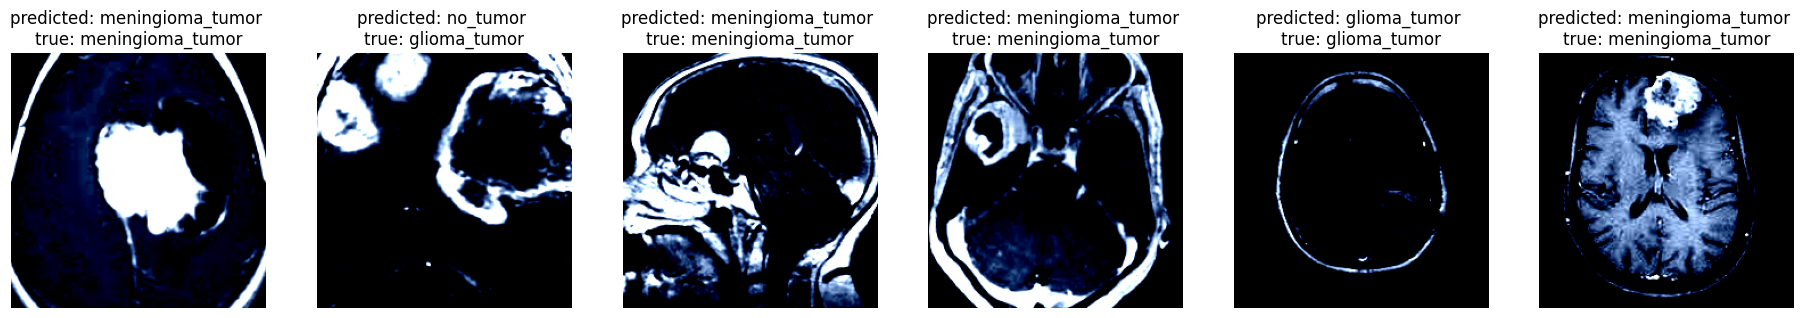

In [35]:
visualize_model(resnet, num_images=6)

In [ ]:
#pic an image to predict



In [ ]:
t_efficient_train = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor(),transforms.Grayscale(num_output_channels =1),transforms.Resize((40,32)), transforms.Normalize((0.48),(0.22)) ]) # order of transforms makes difference
dataset_train_e = ImageFolder('./Training', transform=t_efficient_train) # also transforms.PILToTensor does not give float tensor but uit8, and error message

t_efficient_test = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor(),transforms.Grayscale(num_output_channels=1),transforms.Resize((40,32)),transforms.Normalize((0.48), (0.22))])
dataset_test_e = ImageFolder('./Testing', transform=t_efficient_test)


In [ ]:
#check shape
dataset_train_e[8][0].size()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 40, 32])

In [ ]:
efficient = models.efficientnet_b1(weights = models.EfficientNet_B1_Weights)

#print(efficient) # check for which layer outputs need to be changed

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 63.0MB/s]


Now we need to change classifier part Linear layer as follows:
  - change the out_features to 4
  - adapt the image size to match the input features of 1280

In [ ]:
1280/32 # 1280 is not divisible by 3 , so again we need to reduce num of channels

efficient.classifier = nn.Linear(in_features=1280, out_features = 4)
for w in efficient.classifier.parameters():
    w.requires_grad=True

eff_opt = torch.optim.Adam(efficient.classifier.parameters(), lr = 0.0001)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
dataloader_train_e= DataLoader(dataset_train_e, batch_size=4, shuffle=True)
dataloader_test_e =DataLoader(dataset_test_e, batch_size=4)

In [ ]:
pretrainedModel_train(efficient.classifier, len(dataset_train_e), dataloader_train_e, dataloader_test_e, eff_opt, 25)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
resnet_trainer(efficient.classifier, len(dataset_test_e), dataloader_test_e, eff_opt, 25, train=False) # hm might be ok to create separate function for validation , it seems lie it is not validating per epoch

Epoch 1/25
Loss : 0.34798805845835185 Accuracy: tensor(0.6041) 

Epoch 2/25
Loss : 0.34798805845835185 Accuracy: tensor(0.6041) 

Epoch 3/25
Loss : 0.34798805845835185 Accuracy: tensor(0.6041) 

Epoch 4/25
Loss : 0.34798805845835185 Accuracy: tensor(0.6041) 

Epoch 5/25
Loss : 0.34798805845835185 Accuracy: tensor(0.6041) 

Epoch 6/25


KeyboardInterrupt: ignored